pip install imutils

In [2]:
!pip install --upgrade matplotlib

^C


In [5]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torch.optim import SGD,  Adam
import torch.nn as nn 
import numpy as np
import matplotlib.pyplot as plt
from imutils import paths 
import cv2
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cpu')

In [7]:
def normaLize_(img : np.ndarray):
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0,), (1.0, ))])
    img_togray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resize_img = cv2.resize(img_togray, (28,28))
    vector = transform(resize_img)
    return vector 

In [8]:
def get_data(list_dir,threshold):
    data = []
    i=0
    for i_p in list_dir:
        label = i_p.split(os.path.sep)[-1]
        label = label.split(".")[0]
        if label == "cat": label =0.0
        else: label = 1.0
        img_ = cv2.imread(i_p)
        normalize = normaLize_(img_)
        data.append([normalize, torch.tensor([label], dtype=torch.float32)])
        i+=1
        if i == threshold: break
    return data


In [9]:
path_train = 'D:\\big_data_processing\\source\\lab_5\\dogs-vs-cats\\train'
path_test = 'D:\\big_data_processing\\source\\lab_5\\dogs-vs-cats\\test1'
list_dir_train = list(paths.list_images(path_train))
list_dir_test = list(paths.list_images(path_test))
train_dataset = get_data(list_dir_train, 25000)
train_size = 0.7
test_size = 0.3
training, validation = random_split(train_dataset, [train_size, test_size])
batch_size = 1024
train_dataloader = DataLoader(training, batch_size = batch_size, shuffle  = True)
test_dataloader = DataLoader(validation, batch_size = batch_size, shuffle = True)

In [10]:
class LogisticRegression(nn.Module):
    def __init__(self, n_features):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Sequential(nn.Flatten(),nn.Linear(n_features, 1)).to(device)
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

In [11]:
n_features = 784
model = LogisticRegression(n_features = n_features)
img = cv2.imread(list_dir_test[10])
new_img = normaLize_(img)
criterion = nn.BCELoss()
res = model(new_img)
loss = criterion(res, torch.tensor([[0.0]]))
optimizer = SGD(model.parameters(),  0.001)

In [12]:
res

tensor([[0.5385]], grad_fn=<SigmoidBackward0>)

In [13]:
loss

tensor(0.7732, grad_fn=<BinaryCrossEntropyBackward0>)

In [14]:
epochs = 250
train_losses, test_losses, test_accuracy = [], [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    total = 0.0
    correct = 0.0
    for img, label in train_dataloader:
        optimizer.zero_grad()
        outputs = model(img)
        loss = criterion(outputs, label)
        train_loss += loss.item() * img.size(0)
        loss.backward()
        optimizer.step()
    train_loss /= len(train_dataloader.dataset)
    train_losses.append(train_loss)

    # Evaluate model
    model.eval()
    test_loss = 0.0
    total = 0.0
    correct = 0.0
    with torch.no_grad():
        for img, label in test_dataloader:
            outputs = model(img)
            loss = criterion(outputs, label)
            test_loss += loss.item() * img.size(0)
            y_hat = (outputs >= 0.5).float()
            total += label.size(0)
            correct += (y_hat == label).sum().item()
    test_loss /= len(test_dataloader.dataset)
    test_losses.append(test_loss)

    accuracy = correct / total
    test_accuracy.append(accuracy)
    print(f'Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}')

Epoch 1/250, Train Loss: 0.6951, Test Loss: 0.6960, Test Accuracy: 0.5061
Epoch 2/250, Train Loss: 0.6947, Test Loss: 0.6959, Test Accuracy: 0.5084
Epoch 3/250, Train Loss: 0.6945, Test Loss: 0.6957, Test Accuracy: 0.5067
Epoch 4/250, Train Loss: 0.6944, Test Loss: 0.6956, Test Accuracy: 0.5081
Epoch 5/250, Train Loss: 0.6942, Test Loss: 0.6955, Test Accuracy: 0.5057
Epoch 6/250, Train Loss: 0.6940, Test Loss: 0.6953, Test Accuracy: 0.5063
Epoch 7/250, Train Loss: 0.6939, Test Loss: 0.6952, Test Accuracy: 0.5065
Epoch 8/250, Train Loss: 0.6937, Test Loss: 0.6950, Test Accuracy: 0.5085
Epoch 9/250, Train Loss: 0.6936, Test Loss: 0.6949, Test Accuracy: 0.5105
Epoch 10/250, Train Loss: 0.6934, Test Loss: 0.6948, Test Accuracy: 0.5080
Epoch 11/250, Train Loss: 0.6932, Test Loss: 0.6946, Test Accuracy: 0.5123
Epoch 12/250, Train Loss: 0.6931, Test Loss: 0.6945, Test Accuracy: 0.5103
Epoch 13/250, Train Loss: 0.6929, Test Loss: 0.6943, Test Accuracy: 0.5128
Epoch 14/250, Train Loss: 0.6928, 

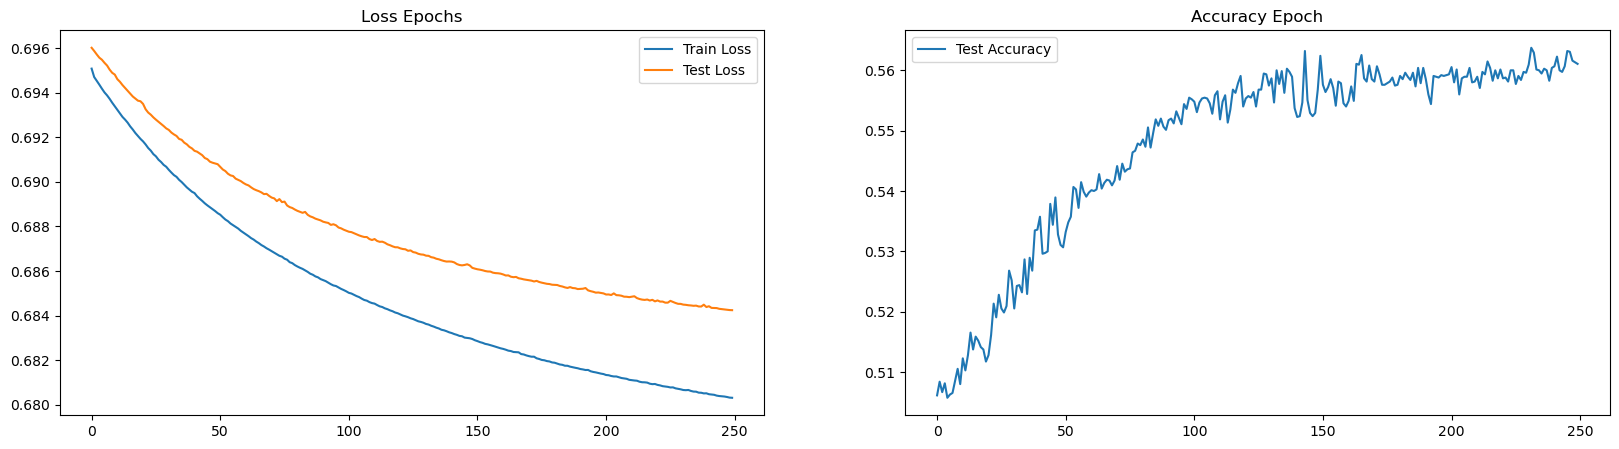

In [15]:
plt.figure(figsize = (20, 5))
plt.subplot(121)
plt.title('Loss Epochs')
plt.plot(train_losses, label = 'Train Loss')
plt.plot(test_losses, label = 'Test Loss')
plt.legend()
plt.subplot(122)
plt.title('Accuracy Epoch')
plt.plot(test_accuracy, label = 'Test Accuracy')
plt.legend()